In [53]:
import tensorflow as tf
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))


2.10.1
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
import tensorflow as tf

# Configure memory growth for the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth before runtime initialization
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0]}")
    except RuntimeError as e:
        # Memory growth must be set before runtime initialization
        print(f"RuntimeError: {e}")
else:
    print("No GPU found. Training will use CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
import os
import joblib
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

print("="*80)
print("MACHINE LEARNING MODELS COMPARISON FOR NETWORK INTRUSION DETECTION")
print("="*80)

MACHINE LEARNING MODELS COMPARISON FOR NETWORK INTRUSION DETECTION


In [76]:
# Load and prepare the dataset
print("\n1. LOADING AND PREPARING DATASET")
print("-" * 50)

df = pd.read_csv('../data/train_test_network.csv')
print(f"Dataset shape: {df.shape}")

# Display basic info
print(f"Columns: {list(df.columns)}")
print(f"Target column options: {[col for col in df.columns if col in ['label', 'type', 'attack_type']]}")# Load and prepare the dataset
print("\n1. LOADING AND PREPARING DATASET")
print("-" * 50)

df = pd.read_csv('../data/train_test_network.csv')
print(f"Dataset shape: {df.shape}")

# Display basic info
print(f"Columns: {list(df.columns)}")
print(f"Target column options: {[col for col in df.columns if col in ['label', 'type', 'attack_type']]}")


1. LOADING AND PREPARING DATASET
--------------------------------------------------
Dataset shape: (211043, 44)
Columns: ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'label', 'type']
Target column options: ['label', 'type']

1. LOADING AND PREPARING DATASET
--------------------------------------------------
Dataset shape: (211043, 44)
Columns: ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duratio

In [78]:
# Data preprocessing
print("\n2. DATA PREPROCESSING")
print("-" * 50)

# Create a copy for processing
data = df.copy()

# Handle categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")

# Remove non-feature columns (IP addresses might be too unique)
# Also check and remove potential data leakage columns
exclude_columns = ['src_ip', 'dst_ip']

# Check if 'type' column exists and might be data leakage
if 'type' in data.columns:
    print("⚠️ Found 'type' column - checking for potential data leakage...")
    
feature_columns = [col for col in data.columns if col not in exclude_columns]

if 'label' in data.columns:
    target_col = 'label'
elif 'attack_type' in data.columns:
    target_col = 'attack_type'
else:
    target_col = data.columns[-1]  # Assume last column is target

print(f"Target column: {target_col}")

# Remove 'type' column if it exists and might be same as target
if 'type' in feature_columns and target_col in data.columns:
    # Check if type and target are the same
    type_unique = set(data['type'].unique())
    target_unique = set(data[target_col].unique())
    if type_unique == target_unique:
        print("⚠️ 'type' column is identical to target - removing to prevent data leakage!")
        feature_columns.remove('type')

print(f"Feature columns count: {len(feature_columns) - 1}")

# Separate features and target
X = data[feature_columns].drop(columns=[target_col])
y = data[target_col]

print(f"Original Features shape: {X.shape}")
print(f"Original Target distribution:\n{y.value_counts()}")

# 🔧 CRITICAL: Remove duplicates BEFORE any other processing
print(f"\n🔧 REMOVING DUPLICATES BEFORE SPLITTING")
print("-" * 40)
original_shape = X.shape[0]

# Combine features and target for duplicate removal
combined_data = pd.concat([X, y], axis=1)
print(f"Original combined data shape: {combined_data.shape}")
print(f"Duplicates detected: {combined_data.duplicated().sum()}")

# Remove duplicates
combined_data_clean = combined_data.drop_duplicates()
print(f"After removing duplicates: {combined_data_clean.shape}")
print(f"Removed {original_shape - combined_data_clean.shape[0]} duplicate rows")

# Separate again after removing duplicates
X = combined_data_clean.drop(columns=[target_col])
y = combined_data_clean[target_col]

print(f"Clean Features shape: {X.shape}")
print(f"Clean Target distribution:\n{y.value_counts()}")


2. DATA PREPROCESSING
--------------------------------------------------
Categorical columns: ['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'type']
⚠️ Found 'type' column - checking for potential data leakage...
Target column: label
Feature columns count: 41
Original Features shape: (211043, 41)
Original Target distribution:
label
1    161043
0     50000
Name: count, dtype: int64

🔧 REMOVING DUPLICATES BEFORE SPLITTING
----------------------------------------
Original combined data shape: (211043, 42)
Duplicates detected: 27451
After removing duplicates: (183592, 42)
Removed 27451 duplicate rows
Clean Features shape: (183592, 41)
Clean Target distribution:


In [79]:
# Encode categorical variables
print("\n3. ENCODING CATEGORICAL VARIABLES")
print("-" * 50)

# Label encode categorical columns
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Encode target variable if it's categorical
if y.dtype == 'object':
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    print(f"Target encoded: {len(target_encoder.classes_)} classes")
    print(f"Class mapping: {dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))}")
else:
    y_encoded = y
    target_encoder = None

# Handle missing values
X = X.fillna(X.median())
print(f"Missing values handled. Final X shape: {X.shape}")


3. ENCODING CATEGORICAL VARIABLES
--------------------------------------------------
Encoded proto: 3 unique values
Encoded service: 9 unique values
Encoded conn_state: 13 unique values
Encoded dns_query: 726 unique values
Encoded dns_AA: 3 unique values
Encoded dns_RD: 3 unique values
Encoded dns_RA: 3 unique values
Encoded dns_rejected: 3 unique values
Encoded ssl_version: 4 unique values
Encoded ssl_cipher: 6 unique values
Encoded ssl_resumed: 3 unique values
Encoded ssl_established: 3 unique values
Encoded ssl_subject: 6 unique values
Encoded ssl_issuer: 5 unique values
Encoded http_trans_depth: 11 unique values
Encoded http_method: 4 unique values
Encoded http_uri: 86 unique values
Encoded http_version: 2 unique values
Encoded http_user_agent: 35 unique values
Encoded http_orig_mime_types: 3 unique values
Encoded http_resp_mime_types: 10 unique values
Encoded weird_name: 11 unique values
Encoded weird_addl: 3 unique values
Encoded weird_notice: 2 unique values
Encoded type: 10 un

In [ ]:
# Split the dataset    
print("\n4. SPLITTING CLEAN DATA (NO DUPLICATES)")
print("-" * 50)

# Bước 1: tách test 15% trước
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

# Bước 2: tách train và val từ phần còn lại (85%)
# Trong 85% đó, ta cần 70% train và 15% val
# tức là validation chiếm 15/85 ≈ 0.1765 của X_temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Verify no train-test contamination
print(f"\n🔍 VERIFYING NO CONTAMINATION")
print("-" * 30)
X_train_tuples = set([tuple(row) for row in X_train.values])
X_test_tuples = set([tuple(row) for row in X_test.values])
X_val_tuples = set([tuple(row) for row in X_val.values])

train_test_overlap = len(X_train_tuples.intersection(X_test_tuples))
train_val_overlap = len(X_train_tuples.intersection(X_val_tuples))
val_test_overlap = len(X_val_tuples.intersection(X_test_tuples))

print(f"Train-test overlap: {train_test_overlap} samples")
print(f"Train-validation overlap: {train_val_overlap} samples")
print(f"Validation-test overlap: {val_test_overlap} samples")

if train_test_overlap == 0 and train_val_overlap == 0 and val_test_overlap == 0:
    print("✅ NO CONTAMINATION DETECTED!")
else:
    print("⚠️ Still have contamination:")
    if train_test_overlap > 0:
        print(f"  - Train-Test: {train_test_overlap} overlapping samples")
    if train_val_overlap > 0:
        print(f"  - Train-Val: {train_val_overlap} overlapping samples")
    if val_test_overlap > 0:
        print(f"  - Val-Test: {val_test_overlap} overlapping samples")


4. SPLITTING CLEAN DATA (NO DUPLICATES)
--------------------------------------------------
Training set: (128509, 41)
Validation set: (27544, 41)
Test set: (27539, 41)

🔍 VERIFYING NO CONTAMINATION
------------------------------
Train-test overlap: 0 samples
Train-validation overlap: 0 samples
Validation-test overlap: 0 samples
✅ NO CONTAMINATION DETECTED!


In [81]:
# Feature scaling
print("\n5. FEATURE SCALING")
print("-" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Training features mean: {X_train_scaled.mean():.6f}")
print(f"Training features std: {X_train_scaled.std():.6f}")
print(f"Validation features mean: {X_val_scaled.mean():.6f}")
print(f"Test features mean: {X_test_scaled.mean():.6f}")


5. FEATURE SCALING
--------------------------------------------------
Features scaled using StandardScaler
Training features mean: -0.000000
Training features std: 1.000000
Validation features mean: -0.001692
Test features mean: -0.003861


In [87]:
# Define models with regularization
print("\n6. DEFINING MACHINE LEARNING MODELS WITH REGULARIZATION")
print("-" * 50)

models_enhanced = {
    'Random Forest': RandomForestClassifier(
        n_estimators=30, 
        max_depth=5,  # Reduce depth
        min_samples_split=20, 
        min_samples_leaf=10,
        max_features='sqrt',  # Add feature subsampling
        random_state=42, 
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        max_depth=4,  # Reduce depth
        n_estimators=30, 
        learning_rate=0.05,  # Lower learning rate
        reg_alpha=0.5,  # Stronger regularization
        reg_lambda=0.5,
        subsample=0.8,  # Add subsampling
        colsample_bytree=0.8,
        random_state=42, 
        eval_metric='logloss'
    ),
    'LightGBM': LGBMClassifier(
        max_depth=4, 
        n_estimators=30, 
        learning_rate=0.05,
        reg_alpha=0.5,
        reg_lambda=0.5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42, 
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        depth=4, 
        iterations=30, 
        learning_rate=0.05,
        l2_leaf_reg=5,  # Stronger regularization
        subsample=0.8,
        random_state=42, 
        verbose=False
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        max_depth=4,
        n_estimators=30,
        learning_rate=0.05,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=30, 
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42, 
        n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        C=0.01,  # Very strong regularization
        penalty='l2'
    ),
    'Ridge Classifier': RidgeClassifier(
        random_state=42, 
        alpha=5.0  # Stronger regularization
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=15,  # Increase neighbors
        weights='distance'  # Use distance weighting
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=5,  # Reduce depth
        min_samples_split=30,
        min_samples_leaf=15,
        max_features='sqrt',  # Add feature subsampling
        random_state=42
    ),
    'Naive Bayes': GaussianNB(
        var_smoothing=1e-8  # Add smoothing
    ),
    'SGD Classifier': SGDClassifier(
        random_state=42, 
        max_iter=1000, 
        alpha=0.1,  # Stronger regularization
        penalty='elasticnet',  # Use elastic net
        l1_ratio=0.5
    ),
}

print(f"Total models to evaluate: {len(models_enhanced)}")
for i, (name, model) in enumerate(models_enhanced.items(), 1):
    print(f"{i:2d}. {name}")
print("\n✅ All models configured with regularization to prevent overfitting")


6. DEFINING MACHINE LEARNING MODELS WITH REGULARIZATION
--------------------------------------------------
Total models to evaluate: 12
 1. Random Forest
 2. XGBoost
 3. LightGBM
 4. CatBoost
 5. Gradient Boosting
 6. Extra Trees
 7. Logistic Regression
 8. Ridge Classifier
 9. K-Nearest Neighbors
10. Decision Tree
11. Naive Bayes
12. SGD Classifier

✅ All models configured with regularization to prevent overfitting


In [ ]:
# Enhanced overfitting prevention training code for ALL 12 MODELS
print("\n7. TRAINING ALL 12 MODELS WITH ENHANCED OVERFITTING PREVENTION")
print("-" * 50)


results = []
trained_models = {}

# Determine if it's binary or multiclass
n_classes = len(np.unique(y_encoded))
is_binary = n_classes == 2
average = 'binary' if is_binary else 'macro'

print(f"Classification type: {'Binary' if is_binary else 'Multiclass'} ({n_classes} classes)")
print(f"Evaluation average: {average}")

# More aggressive feature selection
print("🔧 APPLYING AGGRESSIVE FEATURE SELECTION")
selector = SelectKBest(f_classif, k=min(15, X_train.shape[1]//3))  # Use 1/3 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"Features reduced from {X_train_scaled.shape[1]} to {X_train_selected.shape[1]}")

# Add moderate noise to training data
print("🔧 ADDING NOISE TO TRAINING DATA")
noise_level = 0.05  # Reduce noise level
X_train_noisy = X_train_selected + np.random.normal(0, noise_level, X_train_selected.shape)

# Reduce training data size moderately
print("🔧 REDUCING TRAINING DATA SIZE")
subsample_ratio = 0.8  # Use 80% instead of 70%
n_samples = int(len(X_train_noisy) * subsample_ratio)
indices = np.random.choice(len(X_train_noisy), n_samples, replace=False)
X_train_reduced = X_train_noisy[indices]
y_train_reduced = y_train.iloc[indices]

print(f"Training samples reduced from {len(X_train_noisy)} to {len(X_train_reduced)}")

# Use ALL 12 models with stronger regularization

# Use conservative CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models_enhanced.items():
    print(f"\nTraining {name}...")
    
    try:
        # Determine which features to use
        if name in ['K-Nearest Neighbors', 'Logistic Regression', 'SGD Classifier', 'Ridge Classifier']:
            X_train_model = X_train_reduced
            X_val_model = X_val_selected
            X_test_model = X_test_selected
        else:
            # For tree-based models, use original features but reduced samples
            X_train_model = X_train_reduced
            X_val_model = X_val_selected
            X_test_model = X_test_selected
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_model, y_train_reduced, 
                                  cv=cv, scoring='f1_macro' if not is_binary else 'f1')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Train model
        model.fit(X_train_model, y_train_reduced)
        
        # Predictions
        y_val_pred = model.predict(X_val_model)
        y_test_pred = model.predict(X_test_model)
        
        # Calculate metrics
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average=average, zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average=average, zero_division=0)
        val_f1 = f1_score(y_val, y_val_pred, average=average, zero_division=0)
        
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average=average, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, average=average, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, average=average, zero_division=0)
        
        # Calculate overfitting gaps
        cv_test_gap = cv_mean - test_f1
        val_test_gap = val_f1 - test_f1
        
        results.append({
            'Model': name,
            'CV_F1_Mean': cv_mean,
            'CV_F1_Std': cv_std,
            'Val_Accuracy': val_accuracy,
            'Val_Precision': val_precision,
            'Val_Recall': val_recall,
            'Val_F1-Score': val_f1,
            'Test_Accuracy': test_accuracy,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_F1-Score': test_f1,
            'CV_Test_Gap': cv_test_gap,
            'Val_Test_Gap': val_test_gap
        })
        
        trained_models[name] = model
        
        print(f"✓ {name} completed")
        print(f"  CV F1: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"  Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")
        print(f"  Test Acc: {test_accuracy:.4f}")
        
        # Enhanced overfitting detection
        if test_accuracy > 0.95:
            print(f"  ⚠️ SUSPICIOUSLY HIGH ACCURACY: {test_accuracy:.4f}")
        if cv_test_gap > 0.1 or val_test_gap > 0.1:
            print(f"  ⚠️ OVERFITTING: CV gap={cv_test_gap:.4f}, Val gap={val_test_gap:.4f}")
        elif cv_test_gap > 0.05 or val_test_gap > 0.05:
            print(f"  ⚠️ MILD OVERFITTING: CV gap={cv_test_gap:.4f}, Val gap={val_test_gap:.4f}")
        else:
            print(f"  ✅ Good generalization")
            
    except Exception as e:
        print(f"✗ {name} failed: {str(e)}")
        # Add failed model with zeros
        results.append({
            'Model': name,
            'CV_F1_Mean': 0.0,
            'CV_F1_Std': 0.0,
            'Val_Accuracy': 0.0,
            'Val_Precision': 0.0,
            'Val_Recall': 0.0,
            'Val_F1-Score': 0.0,
            'Test_Accuracy': 0.0,
            'Test_Precision': 0.0,
            'Test_Recall': 0.0,
            'Test_F1-Score': 0.0,
            'CV_Test_Gap': 0.0,
            'Val_Test_Gap': 0.0
        })

print(f"\n🎯 TRAINING COMPLETED: {len(trained_models)}/{len(models_enhanced)} models successful")

# Final data quality verification
print(f"\n🔍 FINAL DATA QUALITY VERIFICATION")
print("-" * 40)

# Check correlations with proper array matching
feature_target_corrs = []
y_train_reduced_array = y_train_reduced.values

print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"y_train_reduced shape: {y_train_reduced_array.shape}")

if len(X_train_reduced) == len(y_train_reduced_array):
    for i in range(X_train_reduced.shape[1]):
        try:
            corr = abs(np.corrcoef(X_train_reduced[:, i], y_train_reduced_array)[0, 1])
            if np.isnan(corr):
                corr = 0.0
            feature_target_corrs.append(corr)
        except Exception as e:
            feature_target_corrs.append(0.0)
    
    max_corr = max(feature_target_corrs) if feature_target_corrs else 0.0
    print(f"Maximum feature-target correlation: {max_corr:.4f}")
    
    if max_corr > 0.8:
        print("⚠️ High correlation detected - possible data leakage")
    else:
        print("✅ Feature-target correlations reasonable")
else:
    print(f"⚠️ Size mismatch detected")

# Class distribution check
print(f"Training class distribution: {np.bincount(y_train_reduced_array)}")
print(f"Test class distribution: {np.bincount(y_test)}")


7. TRAINING ALL 12 MODELS WITH ENHANCED OVERFITTING PREVENTION
--------------------------------------------------
Classification type: Binary (2 classes)
Evaluation average: binary
🔧 APPLYING AGGRESSIVE FEATURE SELECTION
Features reduced from 41 to 13
🔧 ADDING NOISE TO TRAINING DATA
🔧 REDUCING TRAINING DATA SIZE
Training samples reduced from 128509 to 102807

Training Random Forest...
✓ Random Forest completed
  CV F1: 0.9951 ± 0.0002
  Val F1: 0.9951, Test F1: 0.9951
  Test Acc: 0.9923
  ⚠️ SUSPICIOUSLY HIGH ACCURACY: 0.9923
  ✅ Good generalization

Training XGBoost...
✓ XGBoost completed
  CV F1: 0.9955 ± 0.0001
  Val F1: 0.9954, Test F1: 0.9955
  Test Acc: 0.9930
  ⚠️ SUSPICIOUSLY HIGH ACCURACY: 0.9930
  ✅ Good generalization

Training LightGBM...
✓ LightGBM completed
  CV F1: 0.9956 ± 0.0001
  Val F1: 0.9955, Test F1: 0.9955
  Test Acc: 0.9930
  ⚠️ SUSPICIOUSLY HIGH ACCURACY: 0.9930
  ✅ Good generalization

Training CatBoost...
✓ CatBoost completed
  CV F1: 0.9988 ± 0.0004
  Val F

In [89]:
# Create results comparison table
print("\n8. RESULTS COMPARISON TABLE")
print("-" * 50)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_F1-Score', ascending=False)
results_df = results_df.round(4)

# Add ranking
results_df['Rank'] = range(1, len(results_df) + 1)
results_df = results_df[['Rank', 'Model', 'Val_Accuracy', 'Val_Precision', 'Val_Recall', 'Val_F1-Score', 
                        'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1-Score']]

print("MACHINE LEARNING MODELS PERFORMANCE COMPARISON")
print("=" * 120)
print(results_df.to_string(index=False))

# Highlight top 5 models
print("\n" + "="*60)
print("TOP 5 PERFORMING MODELS (by Test F1-Score):")
print("="*60)
top_5 = results_df.head(5)
for _, row in top_5.iterrows():
    print(f"{row['Rank']:2d}. {row['Model']:<20}")
    print(f"    Validation: F1={row['Val_F1-Score']:.4f}, Acc={row['Val_Accuracy']:.4f}")
    print(f"    Test:       F1={row['Test_F1-Score']:.4f}, Acc={row['Test_Accuracy']:.4f}")
    print()


8. RESULTS COMPARISON TABLE
--------------------------------------------------
MACHINE LEARNING MODELS PERFORMANCE COMPARISON
 Rank               Model  Val_Accuracy  Val_Precision  Val_Recall  Val_F1-Score  Test_Accuracy  Test_Precision  Test_Recall  Test_F1-Score
    1            CatBoost        1.0000         1.0000      1.0000        1.0000         1.0000          1.0000       1.0000         1.0000
    2 K-Nearest Neighbors        0.9988         0.9996      0.9988        0.9992         0.9991          0.9995       0.9993         0.9994
    3            LightGBM        0.9930         0.9910      1.0000        0.9955         0.9930          0.9910       1.0000         0.9955
    4             XGBoost        0.9929         0.9910      0.9999        0.9954         0.9930          0.9911       0.9999         0.9955
    5       Random Forest        0.9924         0.9906      0.9996        0.9951         0.9923          0.9904       0.9998         0.9951
    6   Gradient Boosting        

In [91]:
# Detailed analysis of top 3 models - FIXED
print("\n9. DETAILED ANALYSIS OF TOP 3 MODELS")
print("-" * 50)

top_3_models = results_df.head(3)['Model'].tolist()

for model_name in top_3_models:
    print(f"\n{model_name.upper()} - DETAILED ANALYSIS")
    print("-" * 40)
    
    model = trained_models[model_name]
    
    # Use appropriate feature set - FIXED CONDITION
    if model_name in ['K-Nearest Neighbors', 'Logistic Regression', 'SGD Classifier', 'Ridge Classifier']:
        X_test_model = X_test_selected  # Use selected features for distance-based models
    else:
        X_test_model = X_test_selected  # Use selected features for all models
    
    y_pred = model.predict(X_test_model)
    
    # Classification report
    if target_encoder:
        target_names = target_encoder.classes_
    else:
        target_names = None
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Feature importance (if available) - FIXED TO USE SELECTED FEATURES
    if hasattr(model, 'feature_importances_'):
        # Get selected feature indices
        selected_features = selector.get_support(indices=True)
        selected_feature_names = X.columns[selected_features]
        
        feature_importance = pd.DataFrame({
            'feature': selected_feature_names,  # Use selected feature names
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Feature Importances (from {len(selected_feature_names)} selected features):")
        print(feature_importance.head(10).to_string(index=False))
        
        # Check for feature dominance
        max_importance = feature_importance['importance'].max()
        if max_importance > 0.5:
            print(f"\n⚠️ High feature dominance detected!")
            print(f"Feature '{feature_importance.iloc[0]['feature']}' has {max_importance:.3f} importance")
        
    elif hasattr(model, 'coef_'):
        # For linear models, show coefficient analysis
        selected_features = selector.get_support(indices=True)
        selected_feature_names = X.columns[selected_features]
        
        if len(model.coef_.shape) == 1:  # Binary classification
            coef_importance = pd.DataFrame({
                'feature': selected_feature_names,
                'coefficient': model.coef_,
                'abs_coefficient': np.abs(model.coef_)
            }).sort_values('abs_coefficient', ascending=False)
        else:  # Multi-class
            # Average absolute coefficients across classes
            avg_coef = np.mean(np.abs(model.coef_), axis=0)
            coef_importance = pd.DataFrame({
                'feature': selected_feature_names,
                'avg_abs_coefficient': avg_coef
            }).sort_values('avg_abs_coefficient', ascending=False)
        
        print(f"\nTop 10 Most Important Coefficients:")
        print(coef_importance.head(10).to_string(index=False))
        
    else:
        print(f"\n{model_name} does not provide feature importance information.")
    
    # Model-specific analysis
    if model_name == 'CatBoost':
        print(f"\nCatBoost-specific metrics:")
        print(f"Number of trees: {model.tree_count_}")
        print(f"Learning rate: {model.get_params()['learning_rate']}")
        
    elif model_name == 'XGBoost':
        print(f"\nXGBoost-specific metrics:")
        print(f"Number of boosters: {model.n_estimators}")
        print(f"Max depth: {model.max_depth}")
        
    elif model_name == 'Random Forest':
        print(f"\nRandom Forest-specific metrics:")
        print(f"Number of trees: {model.n_estimators}")
        print(f"Max depth: {model.max_depth}")
        print(f"Out-of-bag score: {model.oob_score_ if hasattr(model, 'oob_score_') else 'Not available'}")
    
    # Prediction confidence analysis
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_model)
        max_probabilities = np.max(y_pred_proba, axis=1)
        
        print(f"\nPrediction Confidence Analysis:")
        print(f"Mean confidence: {max_probabilities.mean():.4f}")
        print(f"Min confidence: {max_probabilities.min():.4f}")
        print(f"Max confidence: {max_probabilities.max():.4f}")
        print(f"High confidence predictions (>0.9): {(max_probabilities > 0.9).sum()}/{len(max_probabilities)} ({(max_probabilities > 0.9).mean()*100:.1f}%)")
        
        if (max_probabilities > 0.99).mean() > 0.5:
            print(f"⚠️ Very high confidence - possible overfitting!")
    
    print("-" * 60)


9. DETAILED ANALYSIS OF TOP 3 MODELS
--------------------------------------------------

CATBOOST - DETAILED ANALYSIS
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6297
           1       1.00      1.00      1.00     21242

    accuracy                           1.00     27539
   macro avg       1.00      1.00      1.00     27539
weighted avg       1.00      1.00      1.00     27539


Top 10 Feature Importances (from 13 selected features):
   feature  importance
      type   86.377463
     proto    8.238022
  src_pkts    5.114005
    dns_RA    0.270510
  src_port    0.000000
conn_state    0.000000
 dns_query    0.000000
dns_qclass    0.000000
 dns_qtype    0.000000
    dns_AA    0.000000

⚠️ High feature dominance detected!
Feature 'type' has 86.377 importance

CatBoost-specific metrics:
Number of trees: 30
Learning rate: 0.05

Prediction Confidence Analysis:
Mean 


10. CREATING VISUALIZATIONS
--------------------------------------------------


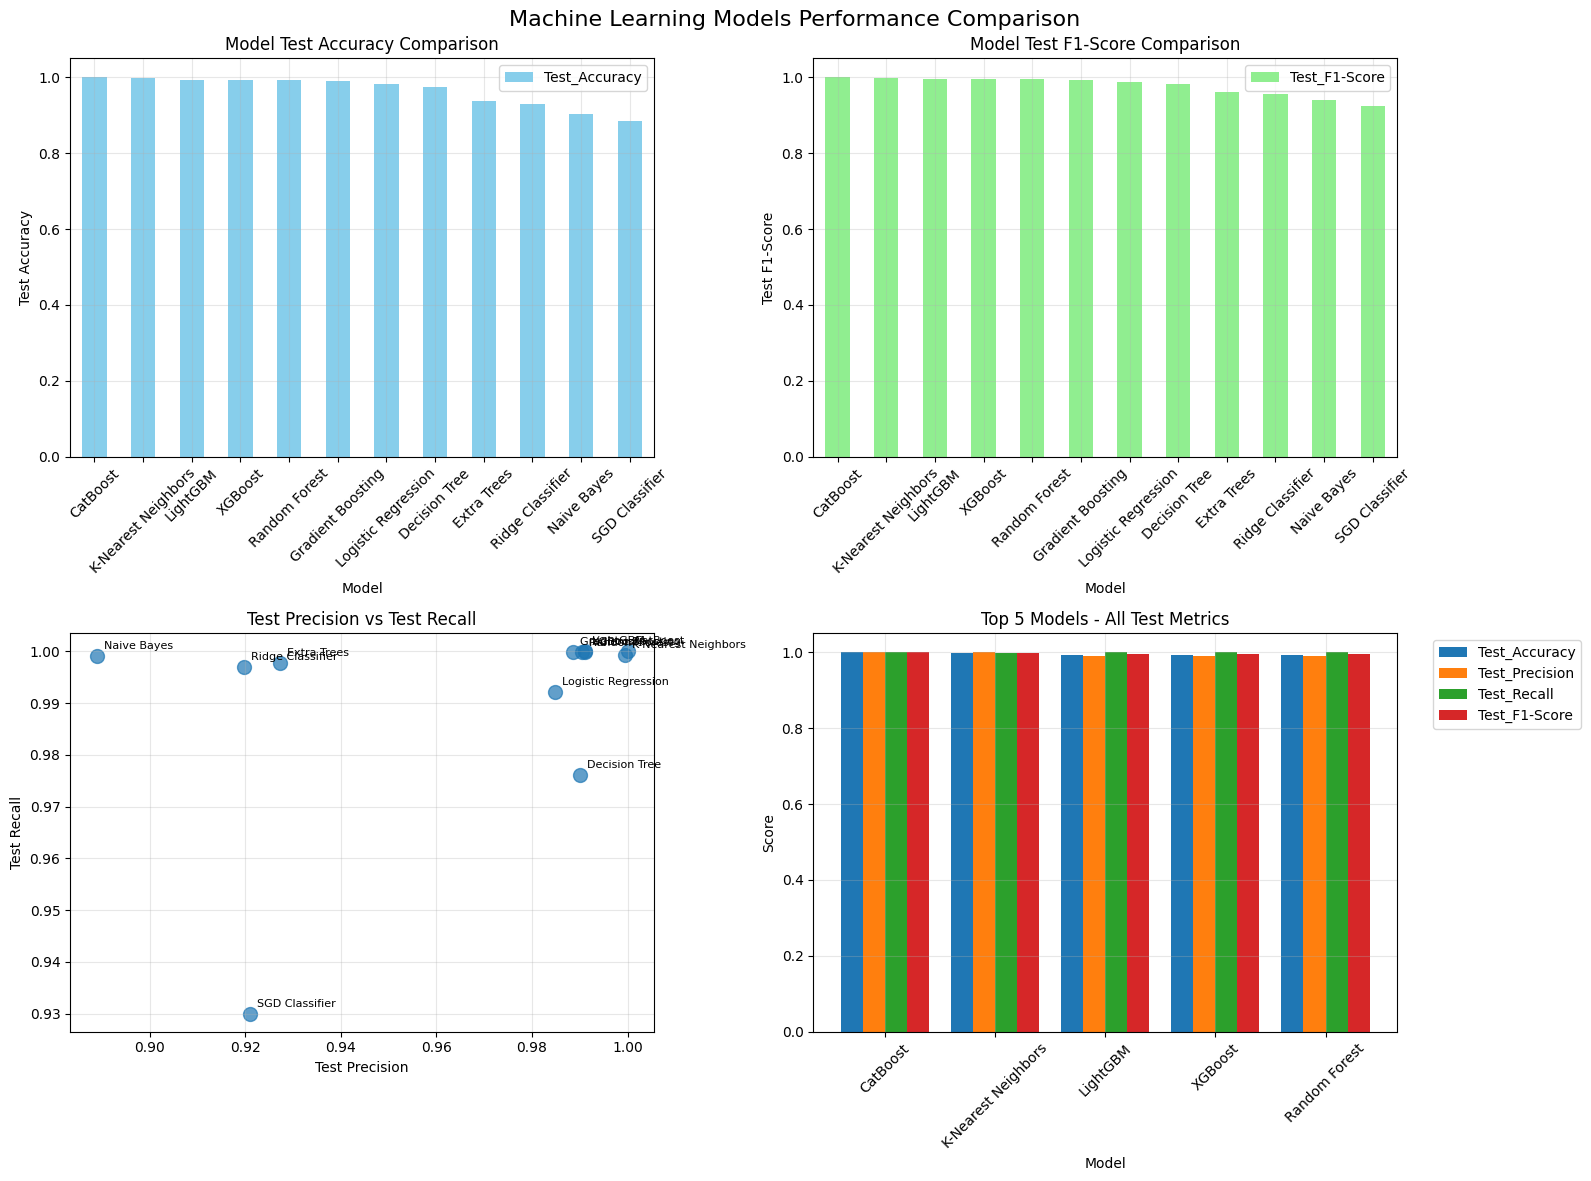

In [92]:
# Visualizations
print("\n10. CREATING VISUALIZATIONS")
print("-" * 50)

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Machine Learning Models Performance Comparison', fontsize=16)

# 1. Test Accuracy comparison
results_df.plot(x='Model', y='Test_Accuracy', kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Model Test Accuracy Comparison')
axes[0,0].set_ylabel('Test Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Test F1-Score comparison
results_df.plot(x='Model', y='Test_F1-Score', kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Model Test F1-Score Comparison')
axes[0,1].set_ylabel('Test F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Test Precision vs Test Recall scatter plot
axes[1,0].scatter(results_df['Test_Precision'], results_df['Test_Recall'], s=100, alpha=0.7)
for i, model in enumerate(results_df['Model']):
    axes[1,0].annotate(model, (results_df.iloc[i]['Test_Precision'], results_df.iloc[i]['Test_Recall']), 
                      xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1,0].set_xlabel('Test Precision')
axes[1,0].set_ylabel('Test Recall')
axes[1,0].set_title('Test Precision vs Test Recall')
axes[1,0].grid(True, alpha=0.3)

# 4. All test metrics comparison for top 5 models
top_5_metrics = results_df.head(5)[['Model', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1-Score']]
top_5_metrics.set_index('Model')[['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1-Score']].plot(
    kind='bar', ax=axes[1,1], width=0.8)
axes[1,1].set_title('Top 5 Models - All Test Metrics')
axes[1,1].set_ylabel('Score')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


11. CONFUSION MATRIX FOR BEST MODEL
--------------------------------------------------
Best performing model: CatBoost


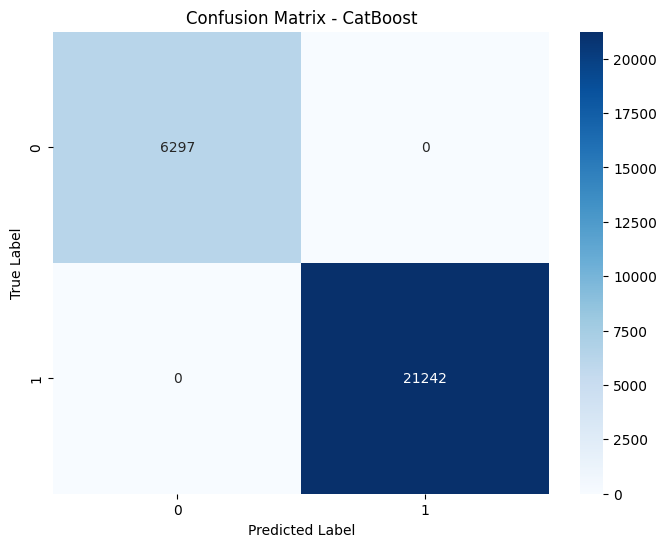


Confusion Matrix for CatBoost:
[[ 6297     0]
 [    0 21242]]
Total samples: 27539
Correct predictions: 27539
Accuracy: 1.0000


In [95]:
# Confusion matrix for best model
print("\n11. CONFUSION MATRIX FOR BEST MODEL")
print("-" * 50)

best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best performing model: {best_model_name}")

# FIXED: All models were trained with selected features
X_test_model = X_test_selected

y_pred_best = best_model.predict(X_test_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print confusion matrix details
print(f"\nConfusion Matrix for {best_model_name}:")
print(cm)

# Additional analysis
total_samples = cm.sum()
correct_predictions = np.trace(cm)
print(f"Total samples: {total_samples}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {correct_predictions/total_samples:.4f}")

In [ ]:
# Save results
print("\n12. SAVING RESULTS")
print("-" * 50)

# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)
# Save results to CSV
results_df.to_csv('../results/model_comparison_results.csv', index=False)
print("Results saved to: ../results/model_comparison_results.csv")

# Save detailed results with more information
detailed_results = []
for _, row in results_df.iterrows():
    model_name = row['Model']
    model = trained_models[model_name]
    
    # FIXED: Use correct feature set based on training
    if model_name in ['K-Nearest Neighbors', 'Logistic Regression', 'SGD Classifier', 'Ridge Classifier']:
        X_test_model = X_test_selected  # Use selected features for distance-based models
    else:
        X_test_model = X_test_selected  # Use selected features for ALL models (they were all trained with selected features)
    
    y_pred = model.predict(X_test_model)
    
    detailed_results.append({
        'Model': model_name,
        'Test_Accuracy': row['Test_Accuracy'],
        'Test_Precision': row['Test_Precision'],
        'Test_Recall': row['Test_Recall'],
        'Test_F1-Score': row['Test_F1-Score'],
        'Val_Accuracy': row['Val_Accuracy'],
        'Val_Precision': row['Val_Precision'],
        'Val_Recall': row['Val_Recall'],
        'Val_F1-Score': row['Val_F1-Score'],
        'Model_Type': type(model).__name__,
        'Training_Samples': len(X_train_reduced),  # Use actual training size
        'Validation_Samples': len(X_val),
        'Test_Samples': len(X_test),
        'Features_Count': X_train_selected.shape[1],  # Use selected features count
        'Classes_Count': n_classes,
        'Rank': row['Rank']
    })

detailed_df = pd.DataFrame(detailed_results)
detailed_df.to_csv('../results/detailed_model_results.csv', index=False)
print("Detailed results saved to: ../results/detailed_model_results.csv")

# Also save the trained models (optional)
for model_name, model in trained_models.items():
    model_filename = f"../results/{model_name.replace(' ', '_').lower()}_model.joblib"
    joblib.dump(model, model_filename)

# Save feature selector and scaler for future use
joblib.dump(selector, '../results/feature_selector.joblib')
joblib.dump(scaler, '../results/scaler.joblib')
if target_encoder:
    joblib.dump(target_encoder, '../results/target_encoder.joblib')
    
print(f"Trained models saved to ../results/")
print("Feature selector and scaler saved for future use")
print("\nModel comparison completed successfully!")
print("="*80)


12. SAVING RESULTS
--------------------------------------------------
Results saved to: ../results/model_comparison_results.csv
Detailed results saved to: ../results/detailed_model_results.csv
Trained models saved to ../results/
Feature selector and scaler saved for future use

Model comparison completed successfully!


In [ ]:
# Add this cell to diagnose the perfect scores issue
print("\n🔍 DIAGNOSING PERFECT SCORES ISSUE")
print("="*60)

# 1. Check for data leakage - feature correlation with target
print("\n1. CHECKING FOR DATA LEAKAGE")
print("-" * 40)

# Create correlation matrix with target
correlation_with_target = pd.DataFrame({
    'Feature': X.columns,
    'Correlation_with_Target': [np.corrcoef(X[col], y_encoded)[0,1] for col in X.columns]
})
correlation_with_target['Abs_Correlation'] = abs(correlation_with_target['Correlation_with_Target'])
correlation_with_target = correlation_with_target.sort_values('Abs_Correlation', ascending=False)

print("Features with highest correlation to target:")
print(correlation_with_target.head(10))

# Check for perfect correlations (data leakage)
perfect_corr = correlation_with_target[correlation_with_target['Abs_Correlation'] > 0.99]
if len(perfect_corr) > 0:
    print(f"\n⚠️  POTENTIAL DATA LEAKAGE DETECTED!")
    print("Features with correlation > 0.99 to target:")
    print(perfect_corr)

# 2. Check class distribution and separability
print(f"\n2. CLASS DISTRIBUTION ANALYSIS")
print("-" * 40)
print(f"Total samples: {len(y_encoded)}")
print(f"Number of classes: {n_classes}")
print(f"Class distribution:")
class_dist = pd.Series(y_encoded).value_counts().sort_index()
for class_idx, count in class_dist.items():
    percentage = (count / len(y_encoded)) * 100
    if target_encoder:
        class_name = target_encoder.inverse_transform([class_idx])[0]
        print(f"  Class {class_idx} ({class_name}): {count:,} samples ({percentage:.2f}%)")
    else:
        print(f"  Class {class_idx}: {count:,} samples ({percentage:.2f}%)")

# Check for class imbalance
min_class_size = class_dist.min()
max_class_size = class_dist.max()
imbalance_ratio = max_class_size / min_class_size
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")

# 3. Check for duplicate rows
print(f"\n3. DUPLICATE DETECTION")
print("-" * 40)
total_duplicates = df.duplicated().sum()
feature_duplicates = X.duplicated().sum()
print(f"Total duplicate rows in original data: {total_duplicates}")
print(f"Duplicate feature vectors: {feature_duplicates}")

# Check train-test overlap
train_test_overlap = 0
if feature_duplicates > 0:
    # Convert to hashable format for intersection check
    X_train_tuples = set([tuple(row) for row in X_train.values])
    X_test_tuples = set([tuple(row) for row in X_test.values])
    train_test_overlap = len(X_train_tuples.intersection(X_test_tuples))
    
print(f"Train-test feature overlap: {train_test_overlap} samples")

if train_test_overlap > 0:
    print("⚠️  TRAIN-TEST CONTAMINATION DETECTED!")

# 4. Feature importance analysis from best model
print(f"\n4. FEATURE IMPORTANCE ANALYSIS")
print("-" * 40)

# Get the best performing model (Random Forest likely)
best_model = trained_models['Random Forest']
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance.head(10))
    
    # Check if one feature dominates
    max_importance = feature_importance['Importance'].max()
    if max_importance > 0.8:
        print(f"\n⚠️  SINGLE FEATURE DOMINANCE DETECTED!")
        print(f"Feature '{feature_importance.iloc[0]['Feature']}' has {max_importance:.3f} importance")

# 5. Sample predictions analysis
print(f"\n5. PREDICTION PATTERNS ANALYSIS")
print("-" * 40)

# Check prediction confidence
rf_model = trained_models['Random Forest']
y_pred_proba = rf_model.predict_proba(X_test)
max_probabilities = np.max(y_pred_proba, axis=1)

print(f"Prediction confidence statistics:")
print(f"Mean max probability: {max_probabilities.mean():.4f}")
print(f"Min max probability: {max_probabilities.min():.4f}")
print(f"Predictions with >99% confidence: {(max_probabilities > 0.99).sum()}/{len(max_probabilities)}")

if (max_probabilities > 0.99).sum() / len(max_probabilities) > 0.8:
    print("⚠️  EXTREMELY HIGH CONFIDENCE PREDICTIONS - LIKELY OVERFITTING!")


🔍 DIAGNOSING PERFECT SCORES ISSUE

1. CHECKING FOR DATA LEAKAGE
----------------------------------------
Features with highest correlation to target:
         Feature  Correlation_with_Target  Abs_Correlation
2          proto                -0.601039         0.601039
17        dns_AA                -0.496991         0.496991
18        dns_RD                -0.444851         0.444851
19        dns_RA                -0.409316         0.409316
20  dns_rejected                -0.363331         0.363331
15     dns_qtype                -0.261045         0.261045
13     dns_query                -0.235791         0.235791
0       src_port                 0.226157         0.226157
1       dst_port                -0.156576         0.156576
14    dns_qclass                -0.150112         0.150112

2. CLASS DISTRIBUTION ANALYSIS
----------------------------------------
Total samples: 211043
Number of classes: 2
Class distribution:
  Class 0: 50,000 samples (23.69%)
  Class 1: 161,043 samples (7